# <center>TMVA Classification Using BDT</center>

In this notebook we still classify di-Higgs new data with Boosted Decision Trees meethod.

In [1]:
import ROOT
from ROOT import TMVA, TTree
import array

ROOT.TMVA.Tools.Instance()
## For PYMVA methods
TMVA.PyMethodBase.PyInitialize()

import itertools

Welcome to JupyROOT 6.14/04


### Filter dataset by region.

This function will let you filter your dataset by region. It's known that SR_1tag is very signal poor, while SR_2tag has a lot a signal.

In [2]:
def filter_region(file, region, signal):
    oldfile = ROOT.TFile(file)
    oldtree = oldfile.Nominal
    signal_file = ROOT.TFile(region+"_"+signal+"_s.root","recreate")
    signal_tree = oldtree.CloneTree(0)
    backg_file = ROOT.TFile(region+"_"+signal+"_b.root","recreate")
    backg_tree = oldtree.CloneTree(0)
    data_file = ROOT.TFile(region+"_"+signal+"_d.root","recreate")
    data_tree = oldtree.CloneTree(0)
    for entry in oldtree:
        if (entry.m_region == region):
            if (entry.sample == "data"):
                data_tree.Fill()
            elif (entry.sample == "Xtohh1000"): #signal
                signal_tree.Fill()
            else:
                backg_tree.Fill()
    signal_tree.AutoSave()   
    backg_tree.AutoSave()
    data_tree.AutoSave()
    return signal_tree, signal_file, backg_tree, backg_file, data_tree, data_file

#Use as
#tree, file = filter_region("data.root", "SR_1tag", "small.root")

## Declare Factory and Input Data

data.root has unlabeled data points (called data) and fakes points. For the background training we'll use only the fakes points.

In [3]:
signal_tree, signal_file, backg_tree, backg_file, data_tree, data_file = filter_region("all_1000.root", "SR_2tag", "Xtohh1000")

In [4]:
outputFile = ROOT.TFile.Open("Higgs_ClassificationOutput.root", "RECREATE")

# Factory
factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification", outputFile,
                      "!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

#signal_tree.Print()

## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input data abd variables 

We add first the signal and background trees in the data loader and then we
define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

In [5]:
loader = ROOT.TMVA.DataLoader("dataset")

### global event weights per tree (see below for setting event-wise weights)
signalWeight     = 1.0
backgroundWeight = 1.0
   
### You can add an arbitrary number of signal or background trees
loader.AddSignalTree    ( signal_tree )
loader.AddBackgroundTree( backg_tree )
loader.SetSignalWeightExpression("EventWeight")

not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']

## Define input variables 
for branch in backg_tree.GetListOfBranches():
    if branch.GetName() in not_cons:
        continue
    loader.AddVariable(branch.GetName())

There are:
- 79336 signal events
- 231046 background events

## Setup Dataset(s)

Setup the DataLoader by splitting events in training and test samples. 
Here we use a random split and a fixed number of training and test events.


In [6]:
## Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";


loader.PrepareTrainingAndTestTree(mycuts, mycutb,
                                  "nTrain_Signal=70%:nTrain_Background=70%:SplitMode=Random:"
                                   "NormMode=NumEvents:!V")

## BDT

In [7]:
## Boosted Decision Trees
factory.BookMethod(loader, ROOT.TMVA.Types.kBDT, "BDT",
                   "!V:NTrees=3000:MinNodeSize=5%:MaxDepth=1:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20:VarTransform=N_AllClasses")

<ROOT.TMVA::MethodBDT object ("BDT") at 0x749b4e0>

## Train Methods

In [8]:
factory.TrainAllMethods()

## Test  all methods

Here we test all methods using the test data set

In [9]:
factory.TestAllMethods()

## Evaluate all methods

Here we evaluate all methods and compare their performances, computing efficiencies, ROC curves etc.. using both training and tetsing data sets. Several histograms are produced which can be examined with the TMVAGui or directly using the output file

In [10]:
factory.EvaluateAllMethods()

                         : 
                         : Evaluation results ranked by best signal efficiency and purity (area)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet       MVA                       
                         : Name:         Method:          ROC-integ
                         : dataset       BDT            : 0.905
                         : -------------------------------------------------------------------------------------------------------------------
                         : 
                         : Testing efficiency compared to training efficiency (overtraining check)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet              MVA              Signal efficiency: from test sample (from training sam

## Plot ROC Curve
We enable JavaScript visualisation for the plots

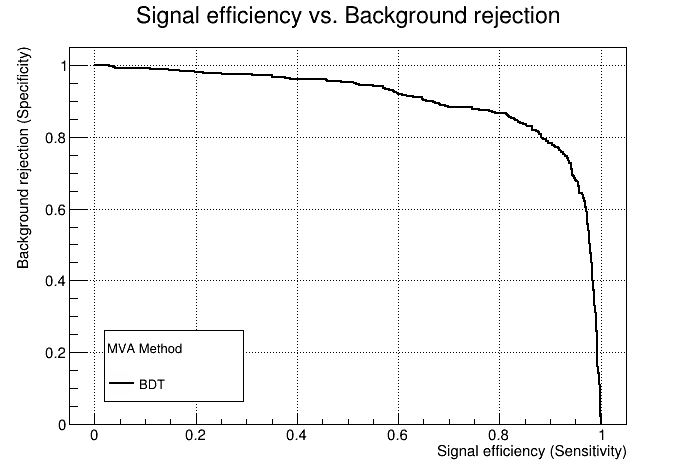

In [11]:
c1 = factory.GetROCCurve(loader)
c1.Draw()

## Prediction

### Declare Reader

In [12]:
TMVA.Tools.Instance()
TMVA.PyMethodBase.PyInitialize();

reader = TMVA.Reader( "!Color:!Silent" )

In [13]:
methodNames = ["BDT"]

dataFile = ROOT.TFile("SR_1tag_Xtohh1000_d.root")
bkgFile = ROOT.TFile("SR_1tag_Xtohh1000_b.root")
sigFile = ROOT.TFile("SR_1tag_Xtohh1000_s.root")

dataTree = dataFile.Nominal
bkgTree = bkgFile.Nominal
sigTree = sigFile.Nominal

### Add Variable

We add variables to the reader exactly in the same way we did for the **DataLoader** during the training

We need to specify the address of the variable in order to pass it to TMVA when we iterate on the TTree

In [14]:
variables = []
i = 0
from array import array

for branch in dataTree.GetListOfBranches():
    if branch.GetName() in not_cons:
        continue
    aux = array('f',[0])
    variables.append(aux)
    reader.AddVariable(branch.GetName(),variables[i])
    i = i+1


### Setup Classifiers

We set up the classifiers by reading the input weights from the appropriate files

The file is stored for example as 

####  *dataset/weights/TMVAClassification_BDT.weights.xml

In [15]:
for methodName in methodNames: 
    weightfile = "dataset/weights/TMVA_Higgs_Classification_" + methodName + ".weights.xml"
    name = ROOT.TString(methodName)
    reader.BookMVA( name, weightfile );

### Evaluation of the classifier on the given input events

We iterate on the input event in the given TTree. We provide as input first the background tree 
We return the output results for the various methods in big numpy array [ number of methods x number of events]
We also fill an histogram for each method.
Note that is important to fill the arrays with the tree entries in order to pass the values to the TMVA::Reader

In [16]:
import numpy as np

# Add weights
def v_out(tree):
    h = {}
    hname = "hdata_BDT"
    h['BDT'] = (ROOT.TH1D(hname,"htitle",60,-1,1))
    
    nevt = tree.GetEntries()

    vout = np.arange(nevt * len(methodNames), dtype='float').reshape( len(methodNames), nevt)

    for ievt, entry in enumerate(tree):
        i = 0    
        for branch in tree.GetListOfBranches():
            name = branch.GetName()
            if name in not_cons:
                continue
            variables[i][0] = getattr(entry,name)
            i += 1

        for j, methodName in enumerate(methodNames): 
            vout[j,ievt] = reader.EvaluateMVA(methodName)
            h[methodName].Fill(vout[j,ievt])
    
    return h, vout

In [17]:
hd, d_vout = v_out(dataTree)
hs, s_vout = v_out(sigTree)
hb, b_vout = v_out(bkgTree)

Warning in <TFile::Append>: Replacing existing TH1: hdata_BDT (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hdata_BDT (Potential memory leak).


In [18]:
print(s_vout)

[[ 0.31823227  0.13633118 -0.22251286 ...  0.22219095  0.07165264
   0.13816061]]


In [19]:
print(b_vout)

[[-0.45695132 -0.45545333 -0.17289253 ... -0.64076484  0.10461788
  -0.04495055]]


### Plot Histogram of output variables

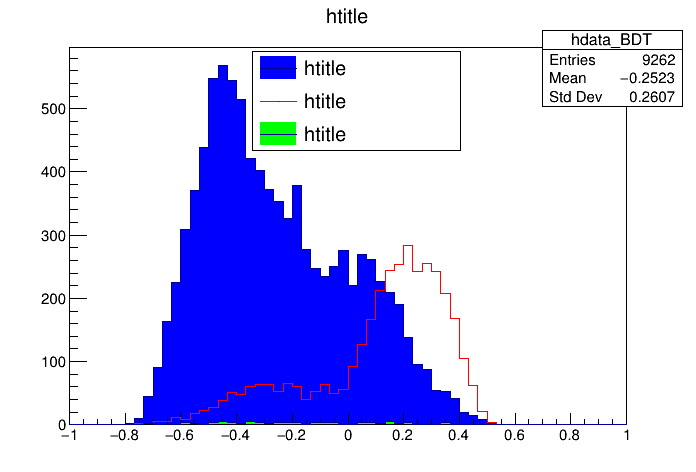

In [20]:
c1 = ROOT.TCanvas()
#c1.DivideSquare( len(hs))
ipad = 0
for name in methodNames: 
    ipad += 1
    pad = c1.cd(ipad)
    h1 = hb[name]
    h1.Draw()
    h2 = hs[name]
    h2.SetLineColor(ROOT.kRed)
    h3 = hd[name]
    h3.SetFillColor(ROOT.kGreen)
    h1.SetFillColor(ROOT.kBlue)
    h2.Draw('Same')
    h3.Draw('Same')
    pad.BuildLegend()

c1.Draw()

In [21]:
dataFile.Close()
sigFile.Close()
bkgFile.Close()

## BDT Complete Function

In [3]:
def get_params(file):
    params = []
    with open(file, 'r') as fp:
        line = fp.readline().rstrip()
        while line:
            params.append(line)
            line = fp.readline().rstrip()       
    return params

In [4]:
def BDT(params, training, config):
    
    signal_file = config+"_s.root"
    backg_file = config+"_b.root"
    output_file = config+"_BDT_Classification.root"
    
    signal_input = ROOT.TFile(signal_file)
    signal_tree = signal_input.Nominal
    
    backg_input = ROOT.TFile(backg_file)
    backg_tree = backg_input.Nominal
    
    outputFile = ROOT.TFile.Open(output_file, "RECREATE")

    # Factory
    factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification", outputFile,
                          "!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

    loader = ROOT.TMVA.DataLoader("dataset")

    ### global event weights per tree (see below for setting event-wise weights)
    signalWeight     = 1.0
    backgroundWeight = 1.0

    ### You can add an arbitrary number of signal or background trees
    loader.AddSignalTree    ( signal_tree )
    loader.AddBackgroundTree( backg_tree )
    loader.SetSignalWeightExpression("EventWeight")

    not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']

    ## Define input variables 
    for branch in backg_tree.GetListOfBranches():
        if branch.GetName() in not_cons:
            continue
        loader.AddVariable(branch.GetName())
        
    mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
    mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";


    loader.PrepareTrainingAndTestTree(mycuts, mycutb, training)
    
    ## Boosted Decision Trees
    factory.BookMethod(loader,ROOT.TMVA.Types.kBDT, "BDT", params)
    
    #loader.OptimizeTuningParameters("ROCIntegral","FitGA")
    
    factory.TrainAllMethods()
    
    factory.TestAllMethods()
    
    factory.EvaluateAllMethods()
    
    #c1 = factory.GetROCCurve(loader)
    #c1.Draw()
    
    integ = factory.GetROCIntegral(loader, "BDT")
    
    # print("ROC integral:", integ)
    
    outputFile.Close()
    signal_input.Close()
    backg_input.Close()
    
    return integ

## Parameters Combination

In [5]:
def write_combs_params(file_params, file_training, arr_NTrees, arr_MinNodeSize, arr_MaxDepth, arr_BoostType, arr_AdaBoostBeta, arr_BaggedSampleFraction, arr_SeparationType, arr_nCuts, arr_nTrain_Signal, arr_nTrain_Background):
    comb_params = list(itertools.product(arr_NTrees, arr_MinNodeSize, arr_MaxDepth, arr_BoostType, arr_AdaBoostBeta, arr_BaggedSampleFraction, arr_SeparationType, arr_nCuts, arr_nTrain_Signal, arr_nTrain_Background))
    with open(file_params, 'w') as params, open(file_training, 'w') as training:
        for cp in comb_params:
            string1 = "!V:NTrees="+str(cp[0])+":MinNodeSize="+str(cp[1])+"%:MaxDepth="+str(cp[2])+":BoostType="+cp[3]+":AdaBoostBeta="+str(cp[4])+":UseBaggedBoost:BaggedSampleFraction="+str(cp[5])+":SeparationType="+cp[6]+":nCuts="+str(cp[7])+":VarTransform=N_AllClasses\n"
            params.write(string1)
            string2 = "nTrain_Signal="+str(cp[8])+"%:nTrain_Background="+str(cp[9])+"%:SplitMode=Random:NormMode=NumEvents:!V\n"
            training.write(string2)

In [26]:
file_params = "bdt_params2.txt"
file_training = "bdt_training2.txt"
arr_NTrees = [4000]
arr_MinNodeSize = [7]
arr_MaxDepth = [3]
arr_BoostType = ["AdaBoost"]#, "Bagging", "Grad"]
arr_AdaBoostBeta = [0.2, 0.5, 0.7]
arr_BaggedSampleFraction = [0.2, 0.5, 0.7]
arr_SeparationType = ["GiniIndexWithLaplace"] #"GiniIndexWithLaplace", "MisClassificationError", "SDivSqrtSPlusB", "RegressionVariance"]
arr_nCuts = [10, 20]
arr_nTrain_Signal = [70, 80]
arr_nTrain_Background = [70, 80]

In [27]:
write_combs_params(file_params, file_training, arr_NTrees, arr_MinNodeSize, arr_MaxDepth, arr_BoostType, arr_AdaBoostBeta, arr_BaggedSampleFraction, arr_SeparationType, arr_nCuts, arr_nTrain_Signal, arr_nTrain_Background)

## Hyperparameter Optimization

In [28]:
def param_opt(config, params, training):
    max_roc = 0
    best_params = ""
    best_train = ""
    print(config)
    print("===============")
    for i in range(len(params)):
        roc = BDT(params[i], training[i], config)
        if roc > max_roc:
            max_roc = roc
            best_params = params[i]
            best_train = training[i]
    print("best parameters:", best_params)
    print("best training:", best_train)
    print("ROC integral:", max_roc)
    return

In [29]:
params_path = "bdt_params2.txt"
params = get_params(params_path)
training_path = "bdt_training2.txt"
training = get_params(training_path)
configs = ["PreSel_0tag_Xtohh1000", "PreSel_1tag_Xtohh1000", "PreSel_2tag_Xtohh1000", 
           "QCDCR_0tag_Xtohh1000", "QCDCR_1tag_Xtohh1000", "QCDCR_2tag_Xtohh1000",
           "SR_0tag_Xtohh1000", "SR_1tag_Xtohh1000", "SR_2tag_Xtohh1000",
           "PreSel_0tag_Xtohh2000", "PreSel_1tag_Xtohh2000", "PreSel_2tag_Xtohh2000",
           "QCDCR_0tag_Xtohh2000", "QCDCR_1tag_Xtohh2000", "QCDCR_2tag_Xtohh2000",
           "SR_0tag_Xtohh2000", "SR_1tag_Xtohh2000", "SR_2tag_Xtohh2000"]
s_end = "_s.root"
b_end = "_b.root"

In [ ]:
param_opt(configs[8], params, training)

SR_2tag_Xtohh1000


# TO DO:

- Optimización de parámetros.
- Inferir un umbral para la clasificación.
- Ordenar el código